In [30]:
%matplotlib inline
import numpy as np
import torch
from matplotlib import pyplot as plt

MNIST  
X = [v1, v2, ..., v784] X:[1,dx]    
H1 = XW1 + b1 W1:[d1, dx] b1:[d1]      
H2 = H1W2 + b2 W2:[d2, d1] b2:[d2]   
H3 = H2W3 + b3 W3:[10, d2] b3:[10]  


[28, 28] -> [784] -> [1, 784]   
[1, 784] * [d1, 784]T + [d1] -> [1, d1] + [d1] -> [1, d1] (H1)    
[1, d1] * [d2, d1]T + [d2] -> [1, d2] + [d2] -> [1, d2] (H2)  
[1, d2] * [10, d2]T + [10] -> [1, 10] + [10] -> [1, 10] (H3)  

$$ pred = W_3 * \{ W_2 [ W_1 X + b_1 ] + b_2 \} + b_3 $$

### Solve Linear Combination
Non-linear Factor  
ReLU function
$$H_1 = ReLU(XW_1 + b1)$$
$$H_2 = ReLU(H_1W_2 + b2)$$
$$H_3 = ReLU(H_2W_3 + b3)$$
$$ pred = ReLU(ReLU(ReLU(XW_1 + b1)W_2 + b_2)W_3 + b3) $$
$$ objective = \sum{(pred - Y)^2} $$
$$ minimize(objective) $$
$$[W_1, W_2, W_3], [b_1, b_2, b_3] $$
$$argmax(pred)$$

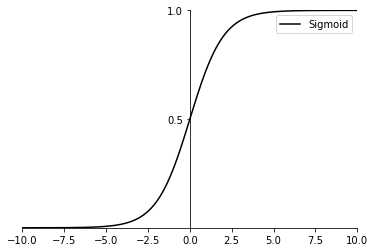

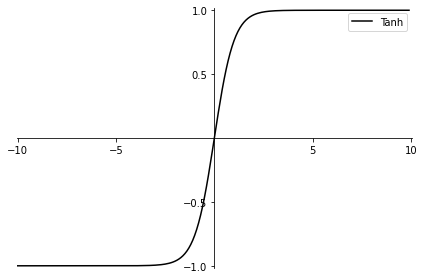

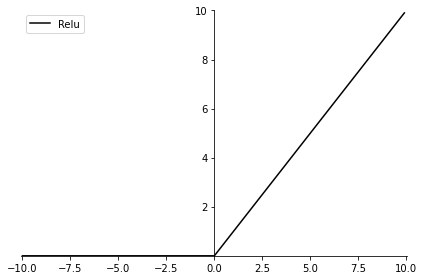

In [31]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
def relu(x):
    return np.where(x < 0, 0, x)

def plot_sigmoid():
    x = np.linspace(-10, 10, 1000)  # 这个表示在-10到10之间生成1000个x值
    y = sigmoid(x)  # 对上述生成的1000个数循环用sigmoid公式求对应的y
    plt.xlim((-10, 10))
    plt.ylim((0.00, 1.00))
    plt.yticks([ 0.5, 1.0], [0.5, 1.0])  # 设置y轴显示的刻度
    plt.plot(x, y, color="black")  # 用上述生成的1000个xy值对生成1000个点
    ax = plt.gca()
    ax.spines['right'].set_color('none')  # 删除右边框设为无
    ax.spines['top'].set_color('none')  # 删除上边框设为无
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data', 0))  # 调整x轴位置
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))  # 调整y轴位置
    plt.savefig("sigmoid.png")
    plt.legend(['Sigmoid'])
    plt.show()

def plot_tanh():
    x = np.arange(-10, 10, 0.1)
    y = tanh(x)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    # ax.spines['bottom'].set_color('none')
    # ax.spines['left'].set_color('none')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.plot(x, y, color = "black")
    plt.xlim([-10.05, 10.05])
    plt.ylim([-1.02, 1.02])
    ax.set_yticks([-1.0, -0.5, 0.5, 1.0])
    ax.set_xticks([-10, -5, 5, 10])
    plt.tight_layout()
    plt.legend(['Tanh'])
    plt.savefig("Tanh.png")
    plt.show()

def plot_relu():
    x = np.arange(-10, 10, 0.1)
    y = relu(x)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    # ax.spines['bottom'].set_color('none')
    # ax.spines['left'].set_color('none')
    ax.spines['left'].set_position(('data', 0))
    ax.plot(x, y, color = "black")
    plt.xlim([-10.05, 10.05])
    plt.ylim([0, 10.02])
    ax.set_yticks([2, 4, 6, 8, 10])
    plt.tight_layout()
    plt.legend(['Relu'])
    plt.savefig("Relu.png")
    plt.show()

if __name__ == "__main__":
    plot_sigmoid()
    plot_tanh()
    plot_relu()



#### Load data
#### Build Modal
#### Train
#### Test

In [32]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from matplotlib import pyplot as plt

In [33]:
print(torch.__version__)

1.10.1+cu102


In [34]:
def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'],loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()

In [35]:
def plot_image(img, label, name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title('{}: {}'.format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [36]:
def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out

In [37]:
# 一次加载多少图片
batch_size = 512
# step1. load dataset 数据加载
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data',train=True,download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(
                                      (0.1307,),(0.3081,)) #正则化
                              ])),
    batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/',train=False,download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(
                                      (0.1307,),(0.3081,)) #正则化
                              ])),
    batch_size=batch_size,shuffle=True)

In [38]:
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


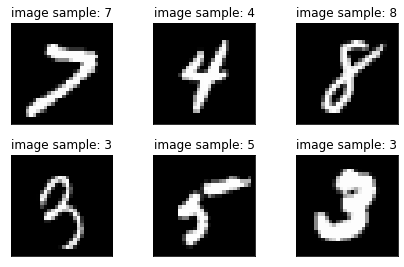

In [39]:
plot_image(x, y, 'image sample')

In [40]:
#### 复习一下Python类class
#类定义
class people:
    #定义基本属性
    name = ''
    age = 0
    #定义私有属性,私有属性在类外部无法直接进行访问
    __weight = 0
    #定义构造方法
    def __init__(self,n,a,w):
        self.name = n
        self.age = a
        self.__weight = w
    def speak(self):
        print("%s 说: 我 %d 岁。" %(self.name,self.age))
 
#单继承示例
class student(people):
    grade = ''
    def __init__(self,n,a,w,g):
        #调用父类的构函
        people.__init__(self,n,a,w)
        self.grade = g
    #覆写父类的方法
    def speak(self):
        print("%s 说: 我 %d 岁了，我在读 %d 年级"%(self.name,self.age,self.grade))
 
#另一个类，多重继承之前的准备
class speaker():
    topic = ''
    name = ''
    def __init__(self,n,t):
        self.name = n
        self.topic = t
    def speak(self):
        print("我叫 %s，我是一个演说家，我演讲的主题是 %s"%(self.name,self.topic))
 
#多重继承
class sample(speaker,student):
    a =''
    def __init__(self,n,a,w,g,t):
        student.__init__(self,n,a,w,g)
        speaker.__init__(self,n,t)
 
test = sample("Tim",25,80,4,"Python")
test.speak()   #方法名同，默认调用的是在括号中参数位置排前父类的方法

我叫 Tim，我是一个演说家，我演讲的主题是 Python


0 0 0.11725349724292755
0 10 0.10119147598743439
0 20 0.09022237360477448
0 30 0.08313341438770294
0 40 0.07719365507364273
0 50 0.07158537209033966
0 60 0.06826061755418777
0 70 0.0652516782283783
0 80 0.05999814718961716
0 90 0.05819942429661751
0 100 0.0538102462887764
0 110 0.05303395912051201
1 0 0.05027095600962639
1 10 0.04788991063833237
1 20 0.046046532690525055
1 30 0.0486043356359005
1 40 0.04381676763296127
1 50 0.0439947172999382
1 60 0.043422989547252655
1 70 0.04287434741854668
1 80 0.04338601604104042
1 90 0.04215715080499649
1 100 0.039106037467718124
1 110 0.041682880371809006
2 0 0.04076627641916275
2 10 0.038256220519542694
2 20 0.036713507026433945
2 30 0.0373212993144989
2 40 0.03620808199048042
2 50 0.03465903922915459
2 60 0.03273940458893776
2 70 0.03174402564764023
2 80 0.035241711884737015
2 90 0.03309834748506546
2 100 0.03358233720064163
2 110 0.036097340285778046


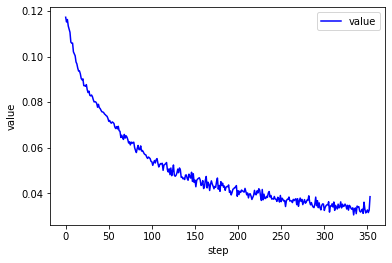

test acc: 0.8793


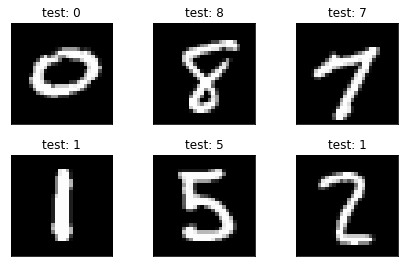

In [42]:
# 网络创建
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #xw+b
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self,x):
        # x:[batch_size,1,28,28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h1 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        x = self.fc3(x)

        return x

net = Net()
# [w1,b1,w2,b1,w3,b3]
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

train_loss = []

# 训练
for epoch in range(3):

    for batch_idx,(x,y) in enumerate(train_loader):

        # x: [b,1,28,28], y:[512]
        # [b,1,28,28]-->[b,feature]
        x = x.view(x.size(0),28*28)
        # --> [b,10]
        out = net(x)
        # --> [b,10]
        y_onehot = one_hot(y)
        # loss = mse(out,y_onehot)
        loss = F.mse_loss(out,y_onehot)
        # 清零梯度
        optimizer.zero_grad()
        # 计算梯度
        loss.backward()
        #w' = w - lr*grad 更新梯度
        optimizer.step()

        train_loss.append(loss.item())

        if batch_idx % 10 == 0:
            print(epoch,batch_idx,loss.item())

plot_curve(train_loss)

# 得到一个比较好的    [w1,b1,w2,b1,w3,b3]


# 验证准确率
total_correct = 0
for x,y in test_loader:
    x = x.view(x.size(0),28*28)
    out = net(x)
    # out: [b,10] --> pred: [b]
    pred = out.argmax(dim = 1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:',acc)

# 直观显示验证
x,y = next(iter(test_loader))
out = net(x.view(x.size(0),28*28))
pred = out.argmax(dim = 1)
plot_image(x,pred,'test')